In [1]:
"""Import Libraries"""

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

import matplotlib.pyplot as plt

2024-12-24 15:54:37.744264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 15:54:37.760930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 15:54:37.767203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 15:54:37.781934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 15:54:38.544262: W tensorflow/compiler/tf2

In [2]:
"""Check if its using GPU"""

print(f"\nNum GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\n")


Num GPUs Available: 1



I0000 00:00:1735073679.775027  126580 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073679.813197  126580 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073679.813375  126580 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
"""Hyperparameters"""

SEED = 42
FOLDER_NAME = "flow_large"
IMAGE_SIZE = (192, 576)
BATCH_SIZE = 2
EPOCHS = 100
DATASET_REPETITION = 1
LATENT_DIM = 1024
CONV_WIDTHS = [32, 64, 128, 256, 512]
DENSE_WIDTHS = [512, 512]
KERNEL = 3
LEARNING_RATE = 2.5e-4
WEIGHT_DECAY = 2.5e-5

In [4]:
"""Load the Dataset"""

def load_dataset(): 
    """
    Loads the dataset for training
    """
    cwd = os.getcwd()
    img_dir = os.path.join(cwd, FOLDER_NAME)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        img_dir, 
        validation_split = None,
        subset=None, 
        seed = SEED,
        image_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),  
        batch_size = None,
        shuffle = True,
        crop_to_aspect_ratio = True,
        pad_to_aspect_ratio = False,
    )
    return train_ds

In [5]:
"""Prepare the Dataset"""

def normalize_image(images, _):    
    # clip pixel values to the range [0, 1]
    return tf.clip_by_value(images / 255, 0.0, 1.0)

def prepare_dataset(train_ds): 
    """
    Prepares the dataset for training, used in combination with load_dataset
    """
    train_ds = (train_ds
                .map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE) # each dataset has the structure
                .cache()                                                   # (image, labels) when inputting to 
                .repeat(DATASET_REPETITION)                                # map
                .shuffle(10 * BATCH_SIZE)
                .batch(BATCH_SIZE, drop_remainder=True)
                .prefetch(buffer_size=tf.data.AUTOTUNE))
    return train_ds

Found 10409 files belonging to 1 classes.


I0000 00:00:1735073681.252654  126580 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073681.252857  126580 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073681.252991  126580 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073681.318071  126580 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

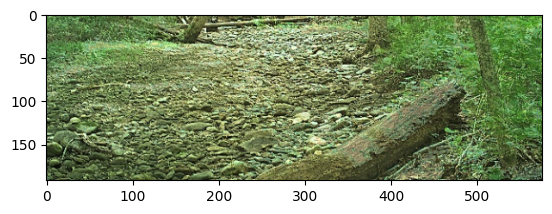

In [6]:
"""Load and Prepare Dataset and Show Sample Image"""

# load and prepare the dataset
dataset = load_dataset()
training_dataset = prepare_dataset(dataset)

# showcase the first image in the iterator
iterator = training_dataset.as_numpy_iterator()
batches = next(iterator)
img = batches[0]

plt.imshow(img)
plt.show()

In [7]:
"""Sampling layer"""

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = keras.random.normal(shape=tf.shape(z_log_var), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


In [8]:
"""Build the Encoder"""

def Build_Encoder(): 
    """Potentially add block depth onto the model in the future to check performance"""
    encoder_inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(CONV_WIDTHS[0], KERNEL, activation="relu", strides=2, padding="same")(encoder_inputs)
    for width in CONV_WIDTHS[1:]: 
        x = layers.Conv2D(width, KERNEL, activation="relu", strides=2, padding="same")(x) 
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
    conv_z_mean = layers.Conv2D(LATENT_DIM, KERNEL, strides=1, padding="same", name="conv_z_mean")(x)
    conv_z_log_var = layers.Conv2D(LATENT_DIM, KERNEL, strides=1, padding="same", name="conv_z_log_var")(x)
    z = Sampling()([conv_z_mean, conv_z_log_var])
    return keras.Model(encoder_inputs, [conv_z_mean, conv_z_log_var, z], name="encoder")

encoder = Build_Encoder()
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 576,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 288,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 144,   │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 144,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 48, 144,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 72,    │     73,856 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 72,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 24, 72,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 36,    │    295,168 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 36,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 12, 36,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 18,     │  1,180,160 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 18,     │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 6, 18,     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_z_mean         │ (None, 6, 18,     │  4,719,616 │ leaky_re_lu_3[0]… │
│ (Conv2D)            │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_z_log_var      │ (None, 6, 18,     │  4,719,616 │ leaky_re_lu_3[0]… │
│ (Conv2D)            │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 6, 18,     │          0 │ conv_z_mean[0][0

 Total params: 11,011,648 (42.01 MB)

 Trainable params: 11,009,728 (42.00 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [9]:
conv_z_log_var = encoder.get_layer("conv_z_log_var")

print(conv_z_log_var.output.shape[1:])

(6, 18, 1024)


In [12]:
"""Build the Decoder"""

from math import prod

# need to manually set this value if you 
# change model architecture
final_shape = (6, 18, 512)

def Build_Decoder(): 
    """Potentially add block depth onto the model in the future to check performance"""
    latent_inputs = keras.Input(shape=(conv_z_log_var.output.shape[1:]))
    print(latent_inputs)
    x = layers.Conv2D(LATENT_DIM, KERNEL, activation="relu", strides=1, padding="same")(latent_inputs)
    # add more convolutional layers here
    for width in CONV_WIDTHS[::-1]: 
        x = layers.Conv2DTranspose(width, KERNEL, activation="relu", strides=2, padding="same")(x) 
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
    decoder_outputs = layers.Conv2DTranspose(3, KERNEL, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder = Build_Decoder()
decoder.summary()

<KerasTensor shape=(None, 6, 18, 1024), dtype=float32, sparse=False, name=keras_tensor_18>


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6, 18, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 18, 1024)    │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 12, 36, 512)    │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 36, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 12, 36, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 24, 72, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 72, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 72, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 48, 144, 128)   │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 144, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 48, 144, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 288, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 96, 288, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 96, 288, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 192, 576, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 192, 576, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 192, 576, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 192, 576, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,729,347 (60.00 MB)

 Trainable params: 15,727,363 (60.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [13]:
"""Build the VAE"""

class VAE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Build_Encoder()
        self.decoder = Build_Decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        print("passed")
        with tf.GradientTape() as tape:
            print("passed")
            z_mean, z_log_var, z = self.encoder(data)
            print("passed")
            reconstruction = self.decoder(z)
            print(reconstruction)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [14]:
"""Train the VAE"""

CHECKPOINT_PATH = "checkpoints/best.weights.h5"

# Create a callback that saves teh models' weights
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, 
                                                         save_best_only=True, 
                                                         save_weights_only=True, 
                                                         verbose=1)

vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
))
vae.fit(x=training_dataset, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint_callback])

<KerasTensor shape=(None, 6, 18, 1024), dtype=float32, sparse=False, name=keras_tensor_53>
passed
passed
passed
Tensor("decoder_1/conv2d_transpose_11_1/Sigmoid:0", shape=(2, 192, 576, 3), dtype=float32)
passed
passed
passed
Tensor("decoder_1/conv2d_transpose_11_1/Sigmoid:0", shape=(2, 192, 576, 3), dtype=float32)


I0000 00:00:1735073786.071314  126648 service.cc:146] XLA service 0x78b1500283a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735073786.071476  126648 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-12-24 15:56:26.233812: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-24 15:56:26.863694: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   7/5204 ━━━━━━━━━━━━━━━━━━━━ 1:56 22ms/step - kl_loss: 4.7443e-04 - loss: 76536.5938 - reconstruction_loss: 76536.5938 

I0000 00:00:1735073793.494098  126648 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5204/5204 ━━━━━━━━━━━━━━━━━━━━ 122s 21ms/step - kl_loss: 4.8894 - loss: 68856.1953 - reconstruction_loss: 68851.2891


/home/informatics/anaconda3/envs/keras3/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


(192, 576, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(6, 18, 1024)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


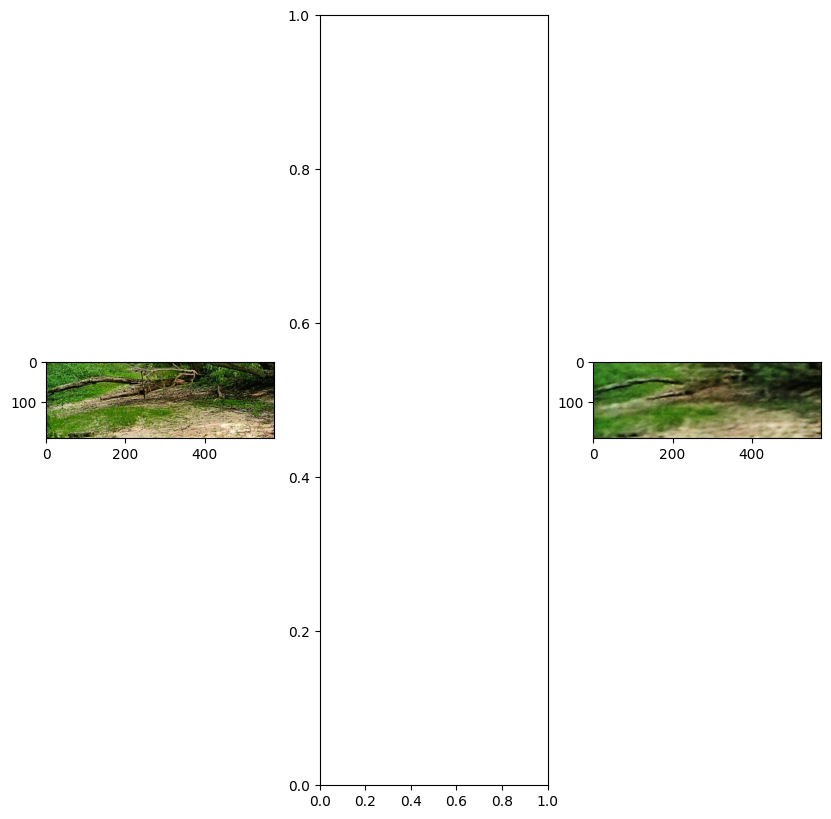

In [21]:
"""Demonstrate Visual Output/Performance of VAE"""

import matplotlib.pyplot as plt

# inference
# latent_dim = 2
# z_sample = np.random.normal(size=(1, latent_dim))
# generated_sample = vae.decoder.predict(z_sample)

# get img
iterator = training_dataset.as_numpy_iterator()
batches = next(iterator)
img = batches[0]

print(img.shape)

# encoder
z_mean, z_log_var, z = vae.encoder.predict(batches)

# Remove the first dimension 
z_sliced = z[0] 

print(z_sliced.shape)

# decoder
generated_sample = vae.decoder.predict(z)

# create plots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# show img
axes[0].imshow(img)
#axes[1].imshow(z[0])
axes[2].imshow(generated_sample[0])

plt.imshow(generated_sample[0])
plt.show()

In [22]:
"""Save the Image for Better Visualization"""

import cv2 as cv

scaled_img = img * 255
scaled_generated_sample = generated_sample[0] * 255

clipped_img = np.clip(scaled_img, 0, 255).astype(np.uint8)
clipped_generated_sample = np.clip(scaled_generated_sample, 0, 255).astype(np.uint8)

cv.imwrite("original_img3.jpg", clipped_img)
cv.imwrite("decoder_img3.jpg", clipped_generated_sample)

True

In [15]:
print(np.min(generated_sample[0]))
print(np.max(generated_sample[0]))

0.00021303314
0.9827183


In [ ]:
"""Save the Weights"""

vae.save_weights('vae_large.weights.h5')

<KerasTensor shape=(None, 48, 144, 64), dtype=float32, sparse=False, name=keras_tensor_44>
<KerasTensor shape=(None, 24, 72, 128), dtype=float32, sparse=False, name=keras_tensor_45>
<KerasTensor shape=(None, 12, 36, 256), dtype=float32, sparse=False, name=keras_tensor_46>
<KerasTensor shape=(None, 6, 18, 512), dtype=float32, sparse=False, name=keras_tensor_47>
<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_49>
<KerasTensor shape=(None, 12, 36, 512), dtype=float32, sparse=False, name=keras_tensor_57>
<KerasTensor shape=(None, 24, 72, 256), dtype=float32, sparse=False, name=keras_tensor_58>
<KerasTensor shape=(None, 48, 144, 128), dtype=float32, sparse=False, name=keras_tensor_59>
<KerasTensor shape=(None, 96, 288, 64), dtype=float32, sparse=False, name=keras_tensor_60>
<KerasTensor shape=(None, 192, 576, 32), dtype=float32, sparse=False, name=keras_tensor_61>
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


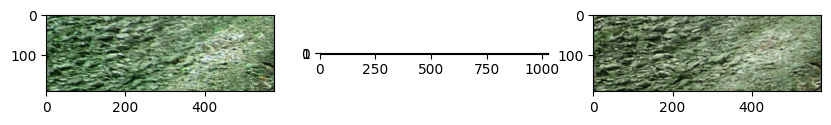

In [26]:
"""Load the Model for Inference"""

vae = VAE()
vae.load_weights("vae_large.weights.h5")

# get img
iterator = training_dataset.as_numpy_iterator()
batches = next(iterator)
img = batches[0]

# encoder
z_mean, z_log_var, z = vae.encoder.predict(batches)

# decoder
generated_sample = vae.decoder.predict(z)

# create plots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# show img
axes[0].imshow(img)
axes[1].imshow(z)
axes[2].imshow(generated_sample[0])

#plt.imshow(generated_sample[0])
plt.show()
